In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import phik
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
raw_data = pd.read_csv('daily_sales_metrics.csv')
raw_data['date'] = pd.to_datetime(raw_data['date'], format='%Y-%m-%d')

raw_data.head()

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1095 non-null   datetime64[ns]
 1   gmv              1095 non-null   int64         
 2   orders           1095 non-null   int64         
 3   sessions         1095 non-null   int64         
 4   marketing_spend  1095 non-null   int64         
 5   is_promo_active  1095 non-null   int64         
 6   day_of_week      1095 non-null   int64         
 7   day_of_year      1095 non-null   int64         
 8   week_of_year     1095 non-null   int64         
 9   month            1095 non-null   int64         
 10  year             1095 non-null   int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 94.2 KB


In [5]:
raw_data = raw_data.set_index('date')
raw_data = raw_data.sort_index()

In [6]:
df = raw_data.copy()

## 1. Проверка данных на пропуски:

In [7]:
df.index.min()

Timestamp('2022-01-01 00:00:00')

In [8]:
df.index.max()

Timestamp('2024-12-30 00:00:00')

In [9]:

df.isna().sum()

gmv                0
orders             0
sessions           0
marketing_spend    0
is_promo_active    0
day_of_week        0
day_of_year        0
week_of_year       0
month              0
year               0
dtype: int64

## 2. Корреляция в данных

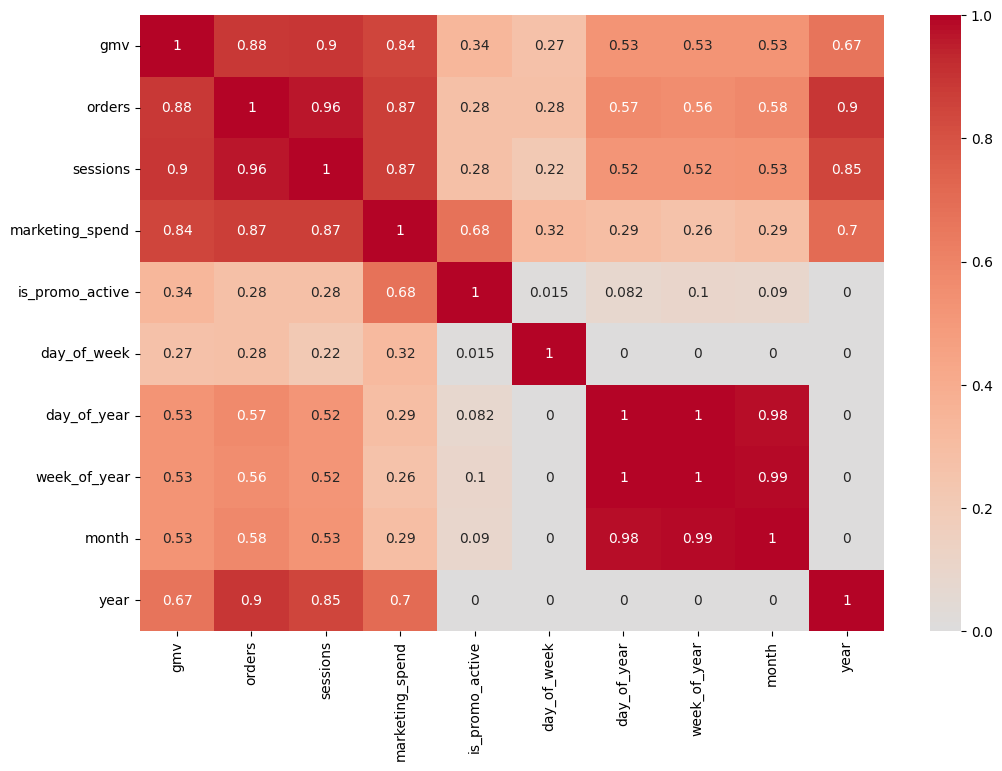

In [10]:
corr_matrix = df.phik_matrix(interval_cols=df.columns)
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.show()

#### Вывод:

На графике видно, что GMV очень сильно зависит от кол-ва сессий пользователей, что и не удивительно, ведь чем больше пользователей будут онлайн - тем вероятнее, что заказы будут в большем объеме продаваться. Так же большой вклад вносит наличие активной промоакции.

Если посмотреть на пересечение is_promo_active и sessions, то можно сделать вывод, что наличие крупных промо акций побуждает пользователей заходить и узнавать подробности (на какой товар, как долго будет длиться акция и т.п.)

#### Сезонность:

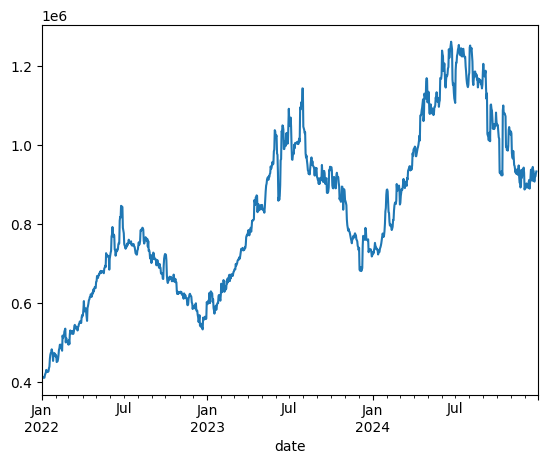

In [11]:
decomposed = seasonal_decompose(x=df['2022-01-01 00:00:00':'2024-12-30 00:00:00']['gmv'])
decomposed.trend.plot()
plt.show()

График сезонности показывает рост GMV к лету и спад к зиме. Я бы предположил, что на платформе доминируют товары для отдыха, одежда и, в целом, тот тип, который может быть актуален летом.

#### Выбросы:

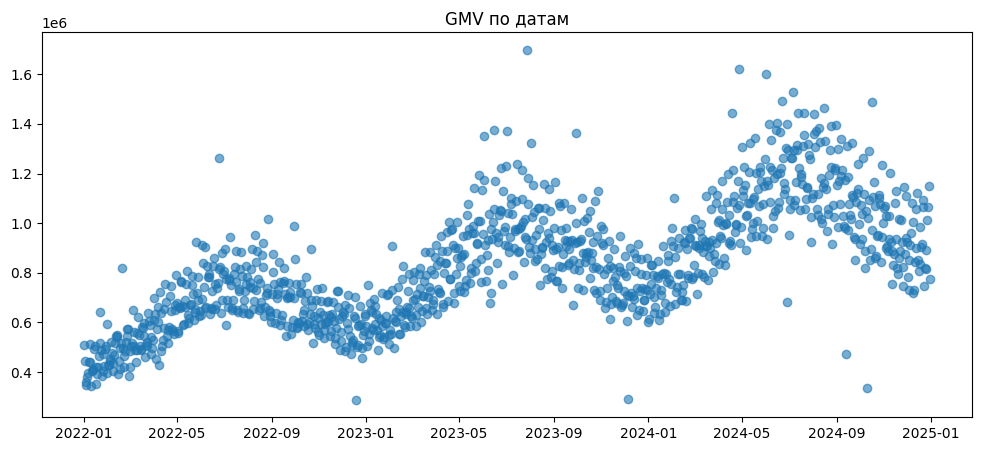

In [12]:
plt.figure(figsize=(12,5))
plt.scatter(df.index, df['gmv'], alpha=0.6)
plt.title('GMV по датам')
plt.show()

Далеко расположенные отдельные точки на графике предположительно являются выбросами. 

In [13]:
df['gmv_zscore'] = stats.zscore(df['gmv'])
outliers = df[df['gmv_zscore'].abs() > 3]
print(outliers[['gmv', 'gmv_zscore']])


                gmv  gmv_zscore
date                           
2023-07-28  1698764    3.706802
2024-04-27  1620170    3.371929
2024-06-01  1601092    3.290642


Будем считать выбросами Z-Score — если |z| > 3.

Так как мы не можем просто взять и удалить их (сдвинется временной интервал), то просто уменьшим данные, заменив их по среднему.

In [14]:
def replace_broken_data(cut_data):
    
    return cut_data[(cut_data['gmv_zscore']>1) & (cut_data['gmv_zscore']<3)].mean()

In [16]:
df['2023-07-28':'2023-07-28'] = replace_broken_data(df['2023-07-01':'2023-07-31'])
df['2024-04-27':'2024-04-27'] = replace_broken_data(df['2024-04-01':'2023-04-30'])
df['2024-07-28':'2024-07-28'] = replace_broken_data(df['2024-06-01':'2023-06-30'])

C:\Users\Fake\AppData\Local\Temp\ipykernel_32096\2212106374.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1168207.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['2023-07-28':'2023-07-28'] = replace_broken_data(df['2023-07-01':'2023-07-31'])
C:\Users\Fake\AppData\Local\Temp\ipykernel_32096\2212106374.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4862.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['2023-07-28':'2023-07-28'] = replace_broken_data(df['2023-07-01':'2023-07-31'])
C:\Users\Fake\AppData\Local\Temp\ipykernel_32096\2212106374.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '165603.4' has dtype incompatible with int64, please 

In [17]:
df['gmv_zscore'] = stats.zscore(df['gmv'])
outliers = df[df['gmv_zscore'].abs() > 3]
print(outliers[['gmv', 'gmv_zscore']])

Empty DataFrame
Columns: [gmv, gmv_zscore]
Index: []


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2022-01-01 to 2024-12-30
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gmv              1093 non-null   float64
 1   orders           1093 non-null   float64
 2   sessions         1093 non-null   float64
 3   marketing_spend  1093 non-null   float64
 4   is_promo_active  1093 non-null   float64
 5   day_of_week      1093 non-null   float64
 6   day_of_year      1093 non-null   float64
 7   week_of_year     1093 non-null   float64
 8   month            1093 non-null   float64
 9   year             1093 non-null   float64
 10  gmv_zscore       0 non-null      float64
dtypes: float64(11)
memory usage: 134.9 KB


Уберем последнюю колонку.

In [19]:
df = df[df.columns[:-1]]
df

,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
date,,,,,,,,,,
2022-01-01,506994.0,1081.0,34861.0,25148.0,0.0,5.0,1.0,52.0,1.0,2022.0
2022-01-02,445834.0,819.0,32858.0,23769.0,0.0,6.0,2.0,52.0,1.0,2022.0
2022-01-03,348150.0,736.0,23081.0,22108.0,0.0,0.0,3.0,1.0,1.0,2022.0
2022-01-04,359418.0,872.0,25166.0,21757.0,0.0,1.0,4.0,1.0,1.0,2022.0
2022-01-05,381439.0,871.0,31082.0,21420.0,0.0,2.0,5.0,1.0,1.0,2022.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-26,891794.0,5410.0,171515.0,54332.0,0.0,3.0,361.0,52.0,12.0,2024.0
2024-12-27,1011484.0,6330.0,219724.0,55346.0,0.0,4.0,362.0,52.0,12.0,2024.0
2024-12-28,1064332.0,6767.0,229631.0,56839.0,0.0,5.0,363.0,52.0,12.0,2024.0


## 3. Feature-Engineering:

Добавим информацию про предыдущие дни через лаг

In [21]:
# Генерация лагов для gmv и orders для всех лагов 1..7
for lag in range(1, 8):
    df[f'gmv_lag_{lag}'] = df['gmv'].shift(lag)
    df[f'orders_lag_{lag}'] = df['orders'].shift(lag)

# Скользящее среднее 7-дней как и раньше
df['gmv_roll_mean_7'] = df['gmv'].shift(1).rolling(window=7).mean()
df['orders_roll_mean_7'] = df['orders'].shift(1).rolling(window=7).mean()

df = df.dropna()


In [22]:
df

,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,gmv_lag_1,orders_lag_1,gmv_lag_2,orders_lag_2,gmv_lag_3,orders_lag_3,gmv_lag_4,orders_lag_4,gmv_lag_5,orders_lag_5,gmv_lag_6,orders_lag_6,gmv_lag_7,orders_lag_7,gmv_roll_mean_7,orders_roll_mean_7
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-08,512868.0,1053.0,38926.0,27318.0,0.0,5.0,8.0,1.0,1.0,2022.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,445834.0,819.0,506994.0,1081.0,410947.714286,884.428571
2022-01-09,440238.0,916.0,36774.0,26716.0,0.0,6.0,9.0,1.0,1.0,2022.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,445834.0,819.0,411786.857143,880.428571
2022-01-10,344412.0,809.0,29591.0,21380.0,0.0,0.0,10.0,2.0,1.0,2022.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,410987.428571,894.285714
2022-01-11,404267.0,929.0,30310.0,23713.0,0.0,1.0,11.0,2.0,1.0,2022.0,344412.0,809.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,410453.428571,904.714286
2022-01-12,408315.0,903.0,34917.0,22999.0,0.0,2.0,12.0,2.0,1.0,2022.0,404267.0,929.0,344412.0,809.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,416860.428571,912.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,891794.0,5410.0,171515.0,54332.0,0.0,3.0,361.0,52.0,12.0,2024.0,813321.0,5723.0,821138.0,4930.0,744942.0,5333.0,1094506.0,6307.0,1065055.0,6054.0,917091.0,6036.0,904286.0,5940.0,908619.857143,5760.428571
2024-12-27,1011484.0,6330.0,219724.0,55346.0,0.0,4.0,362.0,52.0,12.0,2024.0,891794.0,5410.0,813321.0,5723.0,821138.0,4930.0,744942.0,5333.0,1094506.0,6307.0,1065055.0,6054.0,917091.0,6036.0,906835.285714,5684.714286
2024-12-28,1064332.0,6767.0,229631.0,56839.0,0.0,5.0,363.0,52.0,12.0,2024.0,1011484.0,6330.0,891794.0,5410.0,813321.0,5723.0,821138.0,4930.0,744942.0,5333.0,1094506.0,6307.0,1065055.0,6054.0,920320.000000,5726.714286


In [23]:
df['gmv_zscore'] = stats.zscore(df['gmv'])
outliers = df[df['gmv_zscore'].abs() > 3]
print(outliers[['gmv', 'gmv_zscore']])


                  gmv  gmv_zscore
date                             
2024-06-01  1601092.0    3.396220
2024-07-06  1530583.0    3.087371


C:\Users\Fake\AppData\Local\Temp\ipykernel_32096\3962442764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gmv_zscore'] = stats.zscore(df['gmv'])


In [24]:
df['2024-06-01':'2024-06-01'] = replace_broken_data(df['2024-06-01':'2024-06-30'])
df['2024-07-06':'2024-07-06'] = replace_broken_data(df['2024-07-01':'2024-07-31'])


C:\Users\Fake\AppData\Local\Temp\ipykernel_32096\895558684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2024-06-01':'2024-06-01'] = replace_broken_data(df['2024-06-01':'2024-06-30'])
C:\Users\Fake\AppData\Local\Temp\ipykernel_32096\895558684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2024-07-06':'2024-07-06'] = replace_broken_data(df['2024-07-01':'2024-07-31'])


In [25]:
df['gmv_zscore'] = stats.zscore(df['gmv'])
outliers = df[df['gmv_zscore'].abs() > 3]
print(outliers[['gmv', 'gmv_zscore']])

Empty DataFrame
Columns: [gmv, gmv_zscore]
Index: []


C:\Users\Fake\AppData\Local\Temp\ipykernel_32096\3731824252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gmv_zscore'] = stats.zscore(df['gmv'])


In [26]:
df = df[df.columns[:-3]]
df.head()

,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,gmv_lag_1,orders_lag_1,gmv_lag_2,orders_lag_2,gmv_lag_3,orders_lag_3,gmv_lag_4,orders_lag_4,gmv_lag_5,orders_lag_5,gmv_lag_6,orders_lag_6,gmv_lag_7,orders_lag_7
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-08,512868.0,1053.0,38926.0,27318.0,0.0,5.0,8.0,1.0,1.0,2022.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,445834.0,819.0,506994.0,1081.0
2022-01-09,440238.0,916.0,36774.0,26716.0,0.0,6.0,9.0,1.0,1.0,2022.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,445834.0,819.0
2022-01-10,344412.0,809.0,29591.0,21380.0,0.0,0.0,10.0,2.0,1.0,2022.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0
2022-01-11,404267.0,929.0,30310.0,23713.0,0.0,1.0,11.0,2.0,1.0,2022.0,344412.0,809.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0
2022-01-12,408315.0,903.0,34917.0,22999.0,0.0,2.0,12.0,2.0,1.0,2022.0,404267.0,929.0,344412.0,809.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0


In [27]:
df.shape

(1072, 24)

## 4. Обучение модели:

Будем использовать TimeSeriesSplit, так как это специальный метод, предназначенный для кросс-валидации временных рядов

In [28]:
df.head()

,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,gmv_lag_1,orders_lag_1,gmv_lag_2,orders_lag_2,gmv_lag_3,orders_lag_3,gmv_lag_4,orders_lag_4,gmv_lag_5,orders_lag_5,gmv_lag_6,orders_lag_6,gmv_lag_7,orders_lag_7
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-08,512868.0,1053.0,38926.0,27318.0,0.0,5.0,8.0,1.0,1.0,2022.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,445834.0,819.0,506994.0,1081.0
2022-01-09,440238.0,916.0,36774.0,26716.0,0.0,6.0,9.0,1.0,1.0,2022.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,445834.0,819.0
2022-01-10,344412.0,809.0,29591.0,21380.0,0.0,0.0,10.0,2.0,1.0,2022.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0
2022-01-11,404267.0,929.0,30310.0,23713.0,0.0,1.0,11.0,2.0,1.0,2022.0,344412.0,809.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0
2022-01-12,408315.0,903.0,34917.0,22999.0,0.0,2.0,12.0,2.0,1.0,2022.0,404267.0,929.0,344412.0,809.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0


In [29]:
tscv = TimeSeriesSplit(5)

In [30]:
df.shape

(1072, 24)

In [31]:
test = df.iloc[1000:, :]
valid = df.iloc[800:1000, :]
train = df.iloc[:800, :]

In [32]:
X = train.iloc[:, 1:]
y = train['gmv']

In [33]:
X.head()

,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,gmv_lag_1,orders_lag_1,gmv_lag_2,orders_lag_2,gmv_lag_3,orders_lag_3,gmv_lag_4,orders_lag_4,gmv_lag_5,orders_lag_5,gmv_lag_6,orders_lag_6,gmv_lag_7,orders_lag_7
date,,,,,,,,,,,,,,,,,,,,,,,
2022-01-08,1053.0,38926.0,27318.0,0.0,5.0,8.0,1.0,1.0,2022.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,445834.0,819.0,506994.0,1081.0
2022-01-09,916.0,36774.0,26716.0,0.0,6.0,9.0,1.0,1.0,2022.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0,445834.0,819.0
2022-01-10,809.0,29591.0,21380.0,0.0,0.0,10.0,2.0,1.0,2022.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0,348150.0,736.0
2022-01-11,929.0,30310.0,23713.0,0.0,1.0,11.0,2.0,1.0,2022.0,344412.0,809.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0,359418.0,872.0
2022-01-12,903.0,34917.0,22999.0,0.0,2.0,12.0,2.0,1.0,2022.0,404267.0,929.0,344412.0,809.0,440238.0,916.0,512868.0,1053.0,440207.0,901.0,394592.0,911.0,381439.0,871.0


In [34]:
def make_pipline(model='rfr', X=X, y=y):
    if model=='rfr':
        model = RandomForestRegressor()
        # Модель и сетка параметров
        
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5]
        }
        
        # Grid Search с учетом временного разбиения
        grid_search = GridSearchCV(
            model,
            param_grid,
            scoring='neg_mean_absolute_percentage_error',  # метрика
            cv=tscv,
            n_jobs=-1,
            verbose=1
        )
        
        # Запуск подбора
        grid_search.fit(X, y)
        
        # Лучшие параметры
        print('Модель: RFR')
        print("Лучшие параметры:", grid_search.best_params_)
        print(f"Лучшее (среднее) значение MAPE:, {round(-grid_search.best_score_, 4) * 100} %")
        return grid_search.best_estimator_
    elif model=='arima':
 
        mape_scores = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            model = ARIMA(y_train, order=(1,1,1))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(y_test))
            mape = mean_absolute_percentage_error(y_test, y_pred)
            mape_scores.append(mape)
            
        print('Модель: ARIMA')
        print(f"Средний MAPE: {np.mean(mape_scores):.2%}")
        

    elif model=='sarimax':
        
        order = (1, 1, 1)          # (p, d, q)
        seasonal_order = (1, 1, 1, 7)
                
        mape_scores = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            y_pred = model_fit.forecast(steps=len(y_test))
            mape = mean_absolute_percentage_error(y_test, y_pred)
            mape_scores.append(mape)
            
        print('Модель: SARIMA')
        print(f"Средний MAPE: {np.mean(mape_scores):.2%}")
        


In [35]:
best_model = make_pipline(model='rfr')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Модель: RFR
Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Лучшее (среднее) значение MAPE:, 10.67 %


In [36]:
make_pipline(model='sarimax')

C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\b

Модель: SARIMA
Средний MAPE: 23.66%


In [37]:
make_pipline(model='arima')

C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Fake\Desktop\Work\IT\projects

Модель: ARIMA
Средний MAPE: 17.21%


## 5. Визуализация результатов:


MAPE по каждому дню прогноза:
Day +1: MAPE = 0.0510 (5.10%)
Day +2: MAPE = 0.2023 (20.23%)
Day +3: MAPE = 0.0873 (8.73%)
Day +4: MAPE = 0.0057 (0.57%)
Day +5: MAPE = 0.0760 (7.60%)
Day +6: MAPE = 0.1096 (10.96%)
Day +7: MAPE = 0.1150 (11.50%)

Общий MAPE за 7 дней: 0.0924 (9.24%)


C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: Use

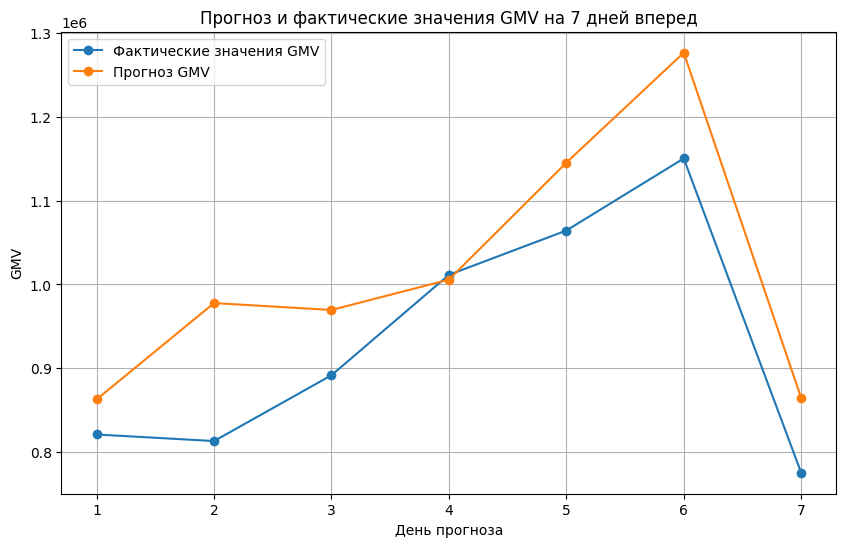

In [38]:
def iterative_forecast(model, df, features, horizon=7):
    df_copy = df.copy().reset_index(drop=True)
    preds = []
    lags = [1, 2, 3, 4, 5, 6, 7]

    for day in range(horizon):
        X_pred = df_copy.loc[len(df_copy) - horizon + day, features].values.reshape(1, -1)
        y_pred = model.predict(X_pred)[0]
        preds.append(y_pred)

        if day < horizon - 1:
            next_idx = len(df_copy) - horizon + day + 1

            # Обновляем лаги gmv
            for lag in lags:
                lag_col = f'gmv_lag_{lag}'
                if lag == 1:
                    df_copy.at[next_idx, lag_col] = y_pred
                else:
                    prev_lag_col = f'gmv_lag_{lag - 1}'
                    df_copy.at[next_idx, lag_col] = df_copy.at[next_idx - 1, prev_lag_col]

            # Обновляем скользящее среднее 7-дневное gmv
            window_start = next_idx - 7
            window_end = next_idx
            window_vals = []
            for i in range(window_start, window_end):
                if i < 0:
                    window_vals.append(np.nan)
                elif i < len(df_copy):
                    window_vals.append(df_copy.at[i, 'gmv'])
                else:
                    pred_idx = i - len(df_copy)
                    if pred_idx < len(preds):
                        window_vals.append(preds[pred_idx])
                    else:
                        window_vals.append(np.nan)
            df_copy.at[next_idx, 'gmv_roll_mean_7'] = np.nanmean(window_vals)

    y_true = df['gmv'].iloc[-horizon:].values

    # Вывод MAPE по каждому дню
    print("\nMAPE по каждому дню прогноза:")
    for i in range(horizon):
        mape_day = mean_absolute_percentage_error([y_true[i]], [preds[i]])
        print(f"Day +{i+1}: MAPE = {mape_day:.4f} ({mape_day*100:.2f}%)")

    # Общий MAPE по всем дням
    mape_total = mean_absolute_percentage_error(y_true, preds)
    print(f"\nОбщий MAPE за {horizon} дней: {mape_total:.4f} ({mape_total*100:.2f}%)")

    # Построение графика
    days = np.arange(1, horizon + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(days, y_true, marker='o', label='Фактические значения GMV')
    plt.plot(days, preds, marker='o', label='Прогноз GMV')
    plt.title(f'Прогноз и фактические значения GMV на {horizon} дней вперед')
    plt.xlabel('День прогноза')
    plt.ylabel('GMV')
    plt.legend()
    plt.grid(True)
    plt.show()

    return preds, y_true


features = X.columns.tolist()
gmv_preds, true_labels = iterative_forecast(best_model, test, features, horizon=7)


C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Fake\Desktop\Work\IT\projects\project_1\Lib\site-packages\sklearn\utils\validation.py:2739: Use


MAPE по каждому дню прогноза:
Day +1: MAPE = 0.0729 (7.29%)
Day +2: MAPE = 0.0171 (1.71%)
Day +3: MAPE = 0.0522 (5.22%)
Day +4: MAPE = 0.0223 (2.23%)
Day +5: MAPE = 0.0929 (9.29%)
Day +6: MAPE = 0.0550 (5.50%)
Day +7: MAPE = 0.0542 (5.42%)
Day +8: MAPE = 0.0627 (6.27%)
Day +9: MAPE = 0.0138 (1.38%)
Day +10: MAPE = 0.0335 (3.35%)
Day +11: MAPE = 0.0354 (3.54%)
Day +12: MAPE = 0.1246 (12.46%)
Day +13: MAPE = 0.0261 (2.61%)
Day +14: MAPE = 0.0359 (3.59%)
Day +15: MAPE = 0.0521 (5.21%)
Day +16: MAPE = 0.0703 (7.03%)
Day +17: MAPE = 0.0584 (5.84%)
Day +18: MAPE = 0.0005 (0.05%)
Day +19: MAPE = 0.1017 (10.17%)
Day +20: MAPE = 0.0907 (9.07%)
Day +21: MAPE = 0.0187 (1.87%)
Day +22: MAPE = 0.2139 (21.39%)
Day +23: MAPE = 0.0937 (9.37%)
Day +24: MAPE = 0.0999 (9.99%)
Day +25: MAPE = 0.0016 (0.16%)
Day +26: MAPE = 0.0855 (8.55%)
Day +27: MAPE = 0.0671 (6.71%)
Day +28: MAPE = 0.0015 (0.15%)
Day +29: MAPE = 0.0585 (5.85%)
Day +30: MAPE = 0.0089 (0.89%)
Day +31: MAPE = 0.0077 (0.77%)
Day +32: MAPE 

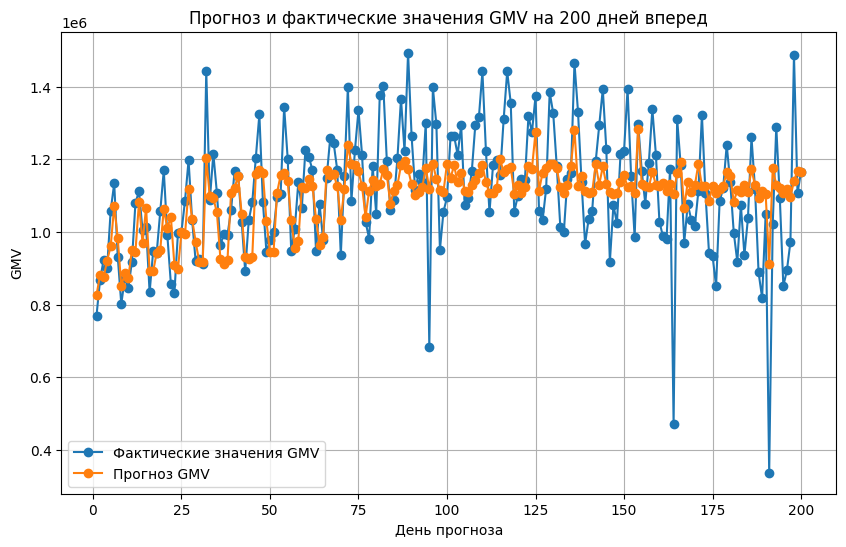

In [39]:
gmv_preds_valid, true_labels_valid = iterative_forecast(best_model, valid, features, horizon=200)

## 6. Детекция аномалий: 

In [40]:
residuals = true_labels_valid - gmv_preds_valid
std_res = residuals.std()


In [41]:
for K in [1,1.5,2]:
    threshold = K * std_res
    anomalies = abs(true_labels - gmv_preds) > threshold
    print(f"K={K}: найдено {anomalies.sum()} аномалий")


K=1: найдено 1 аномалий
K=1.5: найдено 0 аномалий
K=2: найдено 0 аномалий


In [42]:
K = 1
threshold = K * std_res
test_df = test.copy().reset_index()
test_df.loc[test_df.index[-7:], 'pred_gmv'] = gmv_preds
test_df['anomaly'] = abs(test_df['gmv'] - test_df['pred_gmv']) > threshold


In [43]:
# Рассчитаем остатки и отметим аномалии
residuals = abs(test_df['gmv'] - test_df['pred_gmv'])

threshold = K * std_res
test_df['anomaly'] = residuals > threshold

In [44]:
test_df = test_df.tail(7)

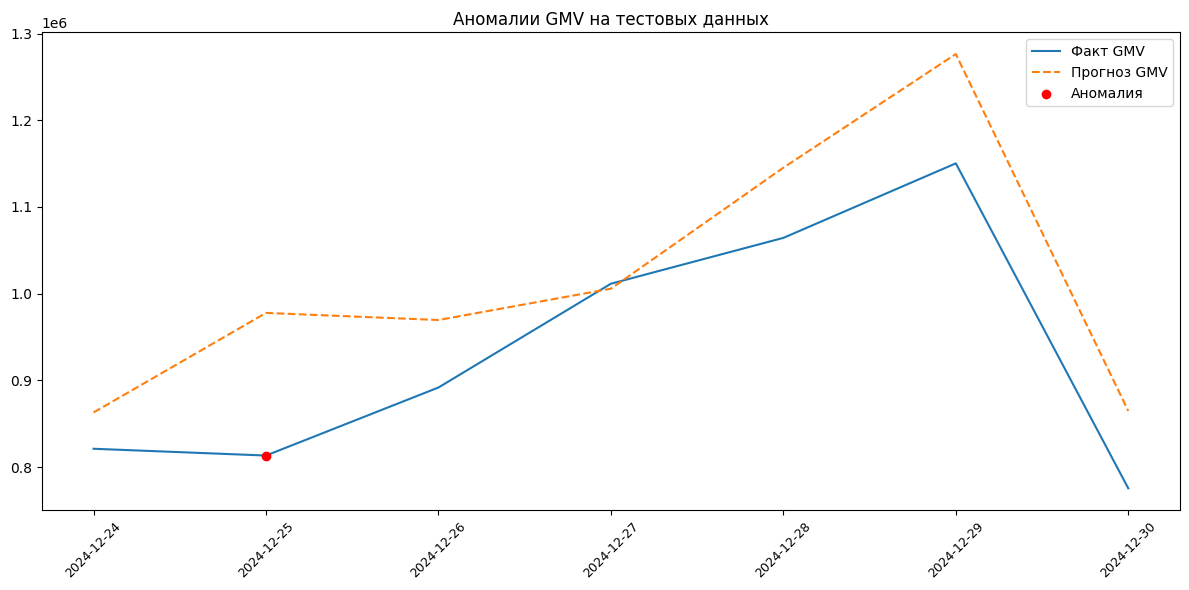

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['date'], test_df['gmv'], label='Факт GMV')
plt.plot(test_df['date'], test_df['pred_gmv'], label='Прогноз GMV', linestyle='--')
plt.scatter(test_df.loc[test_df['anomaly'], 'date'], 
            test_df.loc[test_df['anomaly'], 'gmv'],
            color='red', label='Аномалия', zorder=5)
plt.legend()
plt.xticks(test_df['date'].tolist()[::1], rotation=45, fontsize=9)
plt.title('Аномалии GMV на тестовых данных')
plt.tight_layout()
plt.show()
